In [209]:
#import relevant libraries
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import pickle 
from sklearn.pipeline import Pipeline
import scipy.io as sio
from scipy.stats import spearmanr, pearsonr
from joblib import parallel_backend
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils.fixes import loguniform
import matplotlib as mpl


In [3]:
# Set paths
data_dir='/home/ubuntu/cognition_iowa/data/'
results_dir='/home/ubuntu/cognition_iowa/results/' 

#Load input variables (estimated SC and FC) and save all subjects to one .mat file for eFC prediction (Zijin's code)
nROIs=86
subj_id =  pd.read_csv(data_dir + 'final_subIDs.csv',header=None)[0]
sc = np.zeros([len(subj_id),3655])

for i in range(len(subj_id)):
    filename = data_dir + "sc/%s_nemo_output_chacoconn_fs86subj_nemoSC_volnorm.txt" % (subj_id[i])
    sc_tmp = pd.read_csv(filename, header=0, sep=' ').values
    np.fill_diagonal(sc_tmp, 0)
    sc[i,:] = sc_tmp[np.triu_indices(nROIs,k=1)]
    
sio.savemat(data_dir + 'allstroke_SCs.mat', {'sc':sc}) # used to predict eFC using Zijin's code.

# Load FC
fc = np.zeros([len(subj_id),3655])

for i in range(len(subj_id)):
    filename = data_dir + "fc/%s_FC.txt" % (subj_id[i])
    fc_tmp = pd.read_csv(filename, header=0, sep=' ').values
    np.fill_diagonal(sc_tmp, 0)
    fc[i,:] = fc_tmp[np.triu_indices(nROIs,k=1)]
    
    
# Load demographic variables and outcome measures (TMT and WAIS)
#read in demographic info at first time point
demo =  pd.read_csv(data_dir + 'demographic_final.csv',header=0)

#read in cognitive scores at first time point
tmt = pd.read_csv(data_dir + 'T_MT_A_TIME.csv',header=None)
wais = pd.read_csv(data_dir + 'WAIS_IV_DS_TOTAL_RAW.csv',header=None)

In [56]:
def prepare_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    zeros=X==0
    zeros=np.sum(zeros,0)
    zeros=zeros==X.shape[0]
    X=X[:,~zeros]
    print("Final size of X: " + str(X.shape))
    
    return X

def np_pearson_cor(x, y):
    '''Fast array-based pearson correlation that is more efficient. 
    https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)


def naive_pearson_cor(X, Y):
    '''Naive (scipy-based) pearson correlation. 
    https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    result = np.zeros(shape=(X.shape[1], Y.shape[1]))
    for i in range(X.shape[1]):
        for j in range(Y.shape[1]):
            r, _ = pearsonr(X[:,i], Y[:,j])
            result[i,j] = r
    return result


def feature_select_PCA(x_train, x_test, a):
    """Return values for the top a PCs of x based on PCA of x.
         
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of PCs
         
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features 
            var_expl = variance explained by top a components"""
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
    
    # Feature selection: use only the top n features based on top a PCs in training data 
    pca = PCA(n_components=a, copy=True, random_state=42)
    x_train_featselect = pca.fit(x_train).transform(x_train)
    x_test_featselect = pca.transform(x_test)
    
    var_expl = pca.explained_variance_


    return x_train_featselect,x_test_featselect, var_expl

def feature_select_correlation(x_train, x_test, y, a):
    """Return values for the top a features of x based on abs. value Spearman correlation with y.
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of features to retain
        
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features
        """
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
        
    # Feature selection: use only the top n features based on correlation of training features with y
    correl = abs(np_pearson_cor(x_train, y))
    ind = np.argpartition(correl, -a, 0)[-a:] # select top a features

    # return training/test data with only top features
    x_train_featselect=np.squeeze(x_train[:,ind],2)
    x_test_featselect=np.squeeze(x_test[:,ind],2)

    return x_train_featselect,x_test_featselect


def scale_data(x_train, x_test):
    '''Scale the training data and apply transformation to the test/validation data.

        Inputs:
            x_train = training predictors
            x_test = training predictors 
        
        Returns:
            x_train_scaled
            x_test_scaled '''
    
    # Scale x_train 
    scaler = preprocessing.StandardScaler().fit(x_train)
    
    # apply transformation to train & test set.
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    return x_train_scaled, x_test_scaled


def gcv_ridge(hyperparam, x, y, k, featsel='None', a=x.shape[1]):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=p   
    
    Returns:
        r2 = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=42)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid = feature_select_correlation(x_train, x_valid, y_train, a)

        elif featsel=='PCA':
            x_train, x_valid, var_expl = feature_select_PCA(x_train, x_valid, a)

        #x_train, x_valid = feature_select_correlation(x_train, x_valid, y_train, 10)
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=1)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with total values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)
    
    r2=np.mean(R2)
    return r2

In [ ]:
#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set x data to be the input variable you want to use
#ie fc, sc, or hc
X = np.concatenate([sc, fc], axis=1)
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=42)

# set hyperparameter search space
# range of alphas
n_alphas=20
alpha_start=-3
alpha_end=3
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

#number of principal components
pc_start=10
pc_end=40
n_pcs=pc_end-pc_start+1
pcas = np.linspace(pc_start, pc_end,n_pcs, dtype=int)

gcv_values=np.empty(shape=(len(alphas),len(pcas)),dtype='float')

# iterate through alphas
for alpha in alphas:
    row, = np.where(alphas==alpha)
    for pc in pcas:
        column, = np.where(pcas==pc)
        r2=gcv_ridge(alpha, x, y, 5, 'PCA', pc)
        gcv_values[row,column]=r2 

Final size of X: (101, 6771)


<ipython-input-300-14be6a6aba4d>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


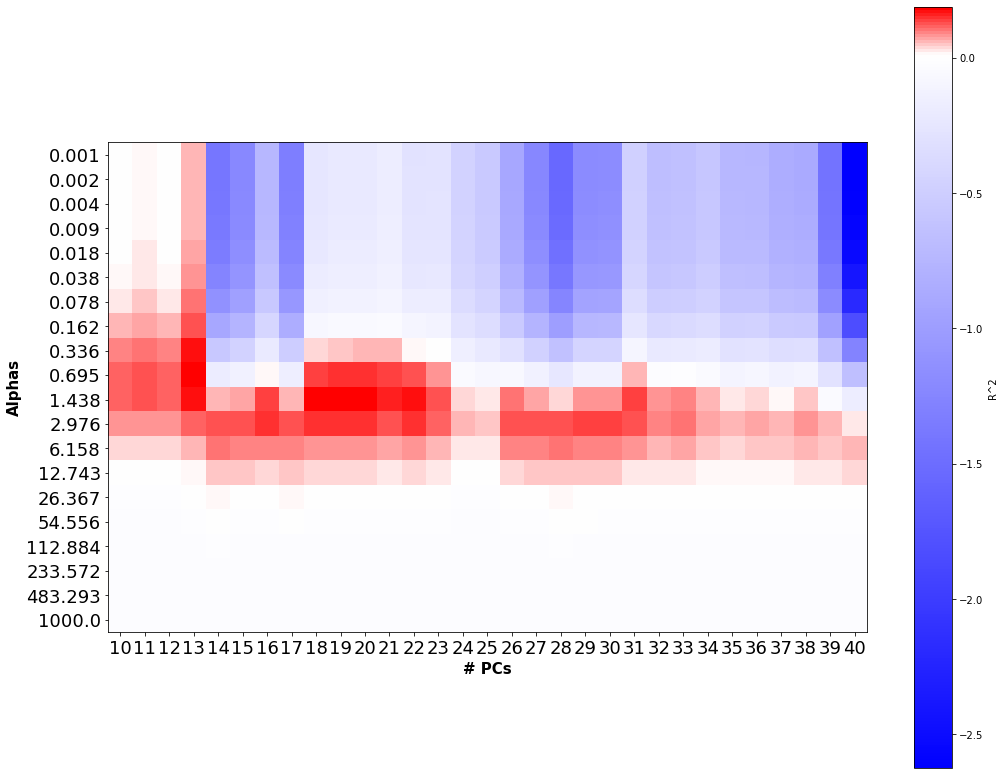

<Figure size 432x288 with 0 Axes>

In [300]:
plt.figure(figsize=(17,14))
shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=0.94, name='shifted')

plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

plt.xlabel('# PCs', fontsize=15, fontweight='bold')
plt.ylabel('Alphas', fontsize=15, fontweight='bold')

ax = plt.axes()

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

xticks= np.linspace(pc_start, pc_end,n_pcs, dtype=int)
yticks= np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

plt.xticks(np.arange(len(pcas)), fontsize=18)
plt.yticks(np.arange(len(alphas)), fontsize=18)

ax.set_xticklabels(xticks)
ax.set_yticklabels(np.round(yticks,3))

#ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
cbar = plt.colorbar()
cbar.set_label('R^2')
plt.show()

plt.savefig(results_dir+'alpha_PCspace_1.png')

In [296]:
np.max(gcv_values)

0.1883589674666259

In [254]:
 np.linspace(20, 30,11, dtype=int)

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [284]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [257]:
print(gcv_values)

[[-2.12548334e-01 -1.80454740e-01 -2.84541193e-01 -2.74358545e-01
  -4.57880259e-01 -5.44224028e-01 -8.92629153e-01 -1.22231056e+00
  -1.54320118e+00 -1.18192871e+00 -1.16688828e+00]
 [-2.11077115e-01 -1.79154701e-01 -2.82912173e-01 -2.72939781e-01
  -4.56315049e-01 -5.42502617e-01 -8.89566408e-01 -1.21841390e+00
  -1.53853977e+00 -1.17810576e+00 -1.16312407e+00]
 [-2.08051529e-01 -1.76481229e-01 -2.79561687e-01 -2.70021577e-01
  -4.53094487e-01 -5.38960340e-01 -8.83264336e-01 -1.21039522e+00
  -1.52894673e+00 -1.17023893e+00 -1.15537807e+00]
 [-2.01869769e-01 -1.71019231e-01 -2.72714500e-01 -2.64057132e-01
  -4.46507224e-01 -5.31713712e-01 -8.70373401e-01 -1.19399005e+00
  -1.50931798e+00 -1.15414494e+00 -1.13953121e+00]
 [-1.89407500e-01 -1.60009398e-01 -2.58904007e-01 -2.52024219e-01
  -4.33197515e-01 -5.17066137e-01 -8.44323531e-01 -1.16082647e+00
  -1.46962665e+00 -1.12161272e+00 -1.10749818e+00]
 [-1.64962054e-01 -1.38418816e-01 -2.31786219e-01 -2.28384995e-01
  -4.06966527e-01 -

In [59]:
# model selection & regularization optimization
# Model selection & hyperparameter optimization
# We optimize alpha using only the training data (X_train, cog_train)
# https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764

p=1
k=5
#joblib-based parallelism to increase speed
with parallel_backend('loky', n_jobs=20):

    #print permutation # you're on
    print('Permutation %d' %(p+1))

    #Splitting the dataset into a hold-out test set and training set for model selection.
    x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)
    print("Size of X: " + str(x.shape))
    print("Size of y: " + str(y.shape))

    # Initializing Regression models
    regr1= linear_model.Ridge(normalize=True, max_iter=1000000)

    #set the param grid be to the hyperparamters you want to search through
    #set hyperparameter grid space you want to search through for the model
    alphas = np.linspace(1e-5, 1, num=100, endpoint=True,dtype=None, axis=0)
    
    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    inner_cv = KFold(n_splits=k, shuffle=True, random_state=3)
    
    paramGrid ={'alpha': alphas}    
    scores = {"R-squared": "r2", "Explained-var": "explained_variance", "MSE":'neg_mean_squared_error'}

    # Setting up GridSearchCV object
    gcv = GridSearchCV(estimator=regr1,
                           param_grid=paramGrid,
                           scoring=scores,
                           n_jobs=1,
                           cv=inner_cv,
                           verbose=0,
                           refit="R-squared")
    gridcvs={}
    gridcvs['Ridge'] = gcv

    best_params=[]

    #Normalize training and test data using scaler fit to training data    
    scaler = preprocessing.StandardScaler().fit(x[train_idx])
    x[train_idx] = scaler.transform(x[train_idx])
    x[test_idx] = scaler.transform(x[test_idx])

    # split data into training and validation ---- inner loop 

    gridcvs['Ridge'].fit(x[train_idx], y[train_idx]) # inner loop hyperparam tuning
    for i in range(0,k):
        plt.plot(gridcvs['Ridge'].cv_results_['param_alpha'], gridcvs['Ridge'].cv_results_['split'+str(i)+'_test_R-squared'])    
        plt.ylim([-10, 1])
    
    print(gridcvs['Ridge'].best_score_)
    print(gridcvs['Ridge'].best_params_)


(101, 3570)

In [43]:
#number of permutations
perms=100
sc_scores_perms=[]
cog = 0

print("Cognition: ", cognition[cog])
for p in range(perms): #iterate permutations

    #joblib-based parallelism to increase speed
    with parallel_backend('loky', n_jobs=16):
        
        #print permutation # you're on
        print('Permutation %d' %(p+1))
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)

        #Splitting the dataset into a hold-out test set and training set for model selection.
        #x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)
        scores_cv=[]
        for train_idx, test_idx in outer_cv.split(X,Y):
            x = X[train_idx]
            y = Y[train_idx]
            x_test = X[test_idx]
            y_test = Y[test_idx]

            # only test one cog score at a time
            y = y[:,cog]
            y_test = y_test[:,cog]

            #store all the y_test values in a separate variable that can be accessed later if needed
            #cogtest[cog,:] = y_test

            #create variables to store nested CV scores, and best parameters from hyperparameter optimisation
            nested_scores = []
            best_params = []

            #Normalize training and test data using scaler fit to training data    
            scaler = preprocessing.StandardScaler().fit(x)
            x = scaler.transform(x)
            x_test = scaler.transform(x_test)

            # Feature selection: use only the top 40 SC edges based on correlation of training features with cognitive score
            correl=[]
            for i in range(0, x.shape[1]):
                correl.append(abs(spearmanr(x[:,i], y)[0]))
            ind = np.argpartition(correl, -40)[-40:]
            x=x[:,ind]
            
            x_test=x_test[:,ind]

            #print("Size of X: " + str(x.shape))
            #print("Size of y: " + str(y.shape))

            #set parameters for inner loop for CV
            inner_cv = KFold(n_splits=k, shuffle=True, random_state=p)

            # Initializing regression model
            regr = linear_model.Ridge(normalize=True, max_iter=1000000)

            #set hyperparameter grid space you want to search through for the model
            alphas = np.logspace(-2,2, num=100, endpoint=True,base=10, axis=0)
            paramGrid = {'alpha': alphas}    

            # regression scoring metrics
            scores = {"R-squared": "r2", "mse":'neg_mean_squared_error'}

            # Set up GridSearchCV object
            gcv = GridSearchCV(estimator=regr,
                                   param_grid=paramGrid,
                                   scoring=scores,
                                   n_jobs=16,
                                   cv=inner_cv,
                                   return_train_score=True,
                                   verbose=0,
                                   refit="R-squared")

            #print("Starting inner loops" )
            # perform model selection (inner loop)
            gcv.fit(x, y) 

            # Save opt. alpha
            best_params.append(list(gcv.best_params_.values()))
            
            # Get the best estimator on the whole training set
            best_model = gcv.best_estimator_
            
            #print("Testing model on hold-out data...")
            # evaluate model on the hold out dataset
            yhat = best_model.predict(x_test)
            
            #print("score: "+ str(gcv.score(x_test, y_test)))
            scores_cv.append(gcv.score(x_test,y_test))
            
        print("mean R^2 performance on test data: " + str(np.mean(scores_cv)))
        sc_scores_perms.append(np.mean(scores_cv))
            

Cognition:  TMT
Permutation 1
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.038139662297032806
Permutation 2
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.017793627829188807
Permutation 3
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 f

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.05526471221335112
Permutation 5
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.13454766419628042
Permutation 6


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.07686717889594052
Permutation 7
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.09656032564432501
Permutation 8
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.01009480856913123
Permutation 9
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.1839

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1078302927777663
Permutation 11
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1300014910501895
Permutation 12


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.0930870143166633
Permutation 13
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.05504648216199868
Permutation 14
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.046652157873226185
Permutation 15
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.024935156598388762
Permutation 16
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.07773459331001506
Permutation 17
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.08262861705776221
Permutation 18
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.008696721821020237
Permutation 19
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.05407991003470625
Permutation 20
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1322666093050238
Permutation 21
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.013585793506877808
Permutation 22
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.07522711467389354
Permutation 23
Fitting 5 folds for each of 100 c

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.19995284165577049
Permutation 26
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1098633275359305
Permutation 27
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.08065583732616377
Permutation 28
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.06524979210992354
Permutation 29
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.09352930482780308
Permutation 30


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.0028600977251091566
Permutation 31
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.10936319409183837
Permutation 32
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.013682372549946753
Permutation 33


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.20802794058904245
Permutation 34
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.08641230849216783
Permutation 35
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.22904705606761908
Permutation 36
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.05286197773670218
Permutation 37
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.12417379737063142
Permutation 38
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.05

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.06657540346876692
Permutation 40
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.06605821440633945
Permutation 41
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.13357090565809276
Permutation 42
Fitting 5 folds for each of 100 

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.14059808082231312
Permutation 47
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.045981028155827476
Permutation 48
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.061

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.06222667354916549
Permutation 54
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.10589146641345104
Permutation 55
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.11180812340634436
Permutation 56
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.04189351411884288
Permutation 57
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.05751685287556134
Permutation 58
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.13144164562405938
Permutation 59


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1356781465409747
Permutation 60
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.21380144625890143
Permutation 61
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.07594829796964105
Permutation 62
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.178

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1640261282602525
Permutation 65
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.2285453262884582
Permutation 66
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.010488578489293165
Permutation 67
Fitting 5 folds for each of 100 ca

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.0009339946229704133
Permutation 68
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.10059860069498934
Permutation 69
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candida

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.050456283189377116
Permutation 74
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1092470853771027
Permutation 75
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.054963752798677865
Permutation 76
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.30986835965746085
Permutation 77
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.2

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.04068144308381701
Permutation 79
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.10051729731093337
Permutation 80
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidate

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.13105599296144566
Permutation 82
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.06347569074202919
Permutation 83
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1222032818520015
Permutation 84
Fitting 5 folds for each of 100 can

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.029888335803308342
Permutation 88
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.0689802288530926
Permutation 89
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.1293262849851071
Permutation 90
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.20283498143559217
Permutation 91
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.025933458033206437
Permutation 92
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.006871117870792998
Permutation 93
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: -0.004347188536057578
Permutation 94
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.11973993887252629
Permutation 95
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candida

/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
mean R^2 performance on test data: 0.04791401283729748


In [7]:
#FC 

#number of permutations
perms=100
fc_scores_perms=[]
cog = 0

print("Cognition: ", cognition[cog])
for p in range(perms): #iterate permutations

    #joblib-based parallelism to increase speed
    with parallel_backend('loky', n_jobs=16):
        
        #print permutation # you're on
        print('Permutation %d' %(p+1))
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)

        #Splitting the dataset into a hold-out test set and training set for model selection.
        #x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)
        scores_cv=[]
        for train_idx, test_idx in outer_cv.split(X,Y):
            x = X[train_idx]
            y = Y[train_idx]
            x_test = X[test_idx]
            y_test = Y[test_idx]

            # only test one cog score at a time
            y = y[:,cog]
            y_test = y_test[:,cog]

            #store all the y_test values in a separate variable that can be accessed later if needed
            #cogtest[cog,:] = y_test

            #create variables to store nested CV scores, and best parameters from hyperparameter optimisation
            nested_scores = []
            best_params = []

            #Normalize training and test data using scaler fit to training data    
            scaler = preprocessing.StandardScaler().fit(x)
            x = scaler.transform(x)
            x_test = scaler.transform(x_test)

            # Feature selection: use only the top 40 SC edges based on correlation of training features with cognitive score
            correl=[]
            for i in range(0, x.shape[1]):
                correl.append(abs(spearmanr(x[:,i], y)[0]))
            ind = np.argpartition(correl, -40)[-40:]
            x=x[:,ind]
            
            x_test=x_test[:,ind]

            #print("Size of X: " + str(x.shape))
            #print("Size of y: " + str(y.shape))

            #set parameters for inner loop for CV
            inner_cv = KFold(n_splits=k, shuffle=True, random_state=p)

            # Initializing regression model
            regr = linear_model.Ridge(normalize=True, max_iter=1000000)

            #set hyperparameter grid space you want to search through for the model
            alphas = np.logspace(-2,2, num=100, endpoint=True,base=10, axis=0)
            paramGrid = {'alpha': alphas}    

            # regression scoring metrics
            scores = {"R-squared": "r2", "mse":'neg_mean_squared_error'}

            # Set up GridSearchCV object
            gcv = GridSearchCV(estimator=regr,
                                   param_grid=paramGrid,
                                   scoring=scores,
                                   n_jobs=16,
                                   cv=inner_cv,
                                   return_train_score=True,
                                   verbose=0,
                                   refit="R-squared")

            #print("Starting inner loops" )
            # perform model selection (inner loop)
            gcv.fit(x, y) 

            # Save opt. alpha
            best_params.append(list(gcv.best_params_.values()))
            
            # Get the best estimator on the whole training set
            best_model = gcv.best_estimator_
            
            #print("Testing model on hold-out data...")
            # evaluate model on the hold out dataset
            yhat = best_model.predict(x_test)
        
            #save optimised alpha values - choose it to be the value corresponding to the median nested score
            #can also use np.max(nested_scores) to choose parameter corresponding to best nested score but might risk overfitting
            # opt_alpha[cog] = best_params
            #print(yhat.shape)
            #print(y_test.shape)
            
            #print("score: "+ str(gcv.score(x_test, y_test)))
            scores_cv.append(gcv.score(x_test,y_test))
            
        print("mean R^2 performance on test data: " + str(np.mean(scores_cv)))
        fc_scores_perms.append(np.mean(scores_cv))
            

Cognition:  TMT
Permutation 1
mean R^2 performance on test data: -0.038729139284281636
Permutation 2
mean R^2 performance on test data: 0.17981758312078402
Permutation 3
mean R^2 performance on test data: 0.06171202053813925
Permutation 4
mean R^2 performance on test data: -0.03354445666576853
Permutation 5
mean R^2 performance on test data: 0.07155347286230036
Permutation 6
mean R^2 performance on test data: -0.10406485278046354
Permutation 7
mean R^2 performance on test data: -0.055318612673401324
Permutation 8
mean R^2 performance on test data: 0.06234173804461256
Permutation 9
mean R^2 performance on test data: -0.07899186259496141
Permutation 10
mean R^2 performance on test data: -0.03731415083383656
Permutation 11
mean R^2 performance on test data: -0.1417357673459993
Permutation 12
mean R^2 performance on test data: 0.022372173296347796
Permutation 13
mean R^2 performance on test data: 0.06702348784429983
Permutation 14
mean R^2 performance on test data: 0.06370142995832517
Perm

In [10]:
np.savetxt('/home/ubuntu/cognition_iowa/results/100perm_ridge_spearmancorr_featureselect_r2_FC.txt', fc_scores_perms, delimiter=',')
np.savetxt('/home/ubuntu/cognition_iowa/results/5foldcv_ridge_spearmancorr_featureselect_r2.txt', scores_cv, delimiter=',')



In [1]:
fc_scores_perms

NameError: name 'fc_scores_perms' is not defined

In [289]:
#iterate through permutations
for p in range(perm):
    #print permutation # you're on
    print('Permutation %d' %(p+1))
    #split data into train and test sets
    x_train, x_test, cog_train, cog_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)

    #iterate through the cognitive metrics you want to predict
    for cog in range (n_cog):

        #print cognitive metrics being predicted 
        print ("Cognition: %s" % cognition[cog])
        
        #set y values for train and test based on     
        y_train = cog_train[:,cog]
        y_test = cog_test[:,cog]
        
        #store all the y_test values in a separate variable that can be accessed later if needed
        cogtest[p,cog,:] = y_test

        #create variables to store nested CV scores, and best parameters from hyperparameter optimisation
        nested_scores = []
        best_params = []


        #optimise regression model using nested CV
        print('Training Models')
        
        #go through the loops of the cross validation
        for i in range(cv_loops):


            #set parameters for inner and outer loops for CV
            inner_cv = KFold(n_splits=k, shuffle=True, random_state=i)
            outer_cv = KFold(n_splits=k, shuffle=True, random_state=i)
            
            #define regressor with grid-search CV for inner loop
            gridSearch = GridSearchCV(estimator=pipe, param_grid=paramGrid, n_jobs=-1, 
                                      verbose=0, cv=inner_cv, scoring='explained_variance')

            #fit regressor
            gridSearch.fit(x_train, y_train)

            #save parameters corresponding to the best score
            best_params.append(list(gridSearch.best_params_.values()))

            #call cross_val_score for outer loop
            nested_score = cross_val_score(gridSearch, X=x_train, y=y_train, cv=outer_cv, 
                                           scoring='explained_variance', verbose=1)

            #record nested CV scores
            nested_scores.append(np.median(nested_score))

            #print how many cv loops are complete
            print("%d/%d Complete" % (i+1,cv_loops))
            
        #once all CV loops are complete, fit models based on optimised hyperparameters    
        print('Testing Models')


        #save optimised alpha values - choose it to be the value corresponding to the median nested score
        #can also use np.max(nested_scores) to choose parameter corresponding to best nested score but might risk overfitting
        opt_alpha[p,cog] = best_params[nested_scores.index(np.median(nested_scores))][0]


        #fit model using optimised hyperparameter
        pca_train = PCA(n_components=1)
        x_train_pca=pca_train.fit_transform(x_train)
        model = Ridge(normalize=True, max_iter=1000000,alpha = opt_alpha[p,cog])

        model.fit(x_train_pca, y_train);
        
        #compute r^2 (coefficient of determination)
        r2[p,cog]=model.score(pca_train.transform(x_test),y_test)

        #generate predictions from model
        preds[p,cog,:] = model.predict(pca_train.transform(x_test)).ravel()
        
        #compute explained variance 
        var[p,cog] = explained_variance_score(y_test, preds[p,cog,:])

        #compute correlation between true and predicted
        corr[p,cog] = np.corrcoef(y_test, preds[p,cog,:])[1,0]

        #extract feature importance
        pca_comp[p,:,:,cog] = pca_train.components_
        featimp[p,:,cog] = model.coef_

#save all of the outputs once everything is done
#filepath is where you want to store it

#np.savetxt('results/r2.txt', r2, delimiter=',')
#np.savetxt('results/var.txt', var, delimiter=',')
#np.savetxt('results/corr.txt', corr, delimiter=',')
#np.savetxt('results/alpha.txt', opt_alpha, delimiter=',')

#np.savetxt('results/sc_dmem_featimp.txt', featimp[:,:,0], delimiter=',')
#np.savetxt('results/sc_trlsB_featimp.txt', featimp[:,:,1], delimiter=',')

#np.savetxt('results/sc_dmem_preds.txt', preds[:,0,:], delimiter=',')
#np.savetxt('results/sc_trlsB_preds.txt', preds[:,1,:], delimiter=',')

#np.savetxt('results/sc_dmem_cogtest.txt', cogtest[:,:,0], delimiter=',')
#np.savetxt('results/sc_trlsB_cogtest.txt', cogtest[:,:,1], delimiter=',')

In [282]:
len(correl)

3201

In [301]:
print(x.shape)

(80, 3201)


In [302]:

print(x.shape)

(80, 3201)


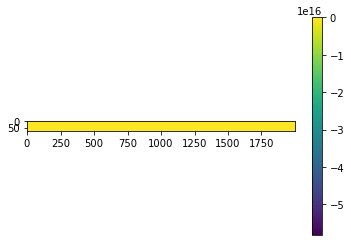

In [101]:
plt.imshow(x[1:100,1:2000])
plt.colorbar()
plt.show()

In [279]:
len(correl)

80

In [256]:
np.corr(x, y)

AttributeError: module 'numpy' has no attribute 'correlation'

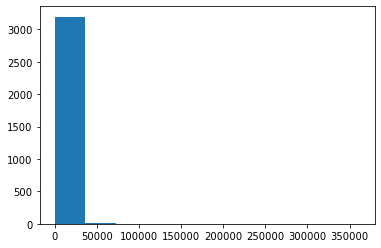

In [142]:
plt.hist(X[1,:])
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)


(array([3.195e+03, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([     0.  ,  36154.65,  72309.3 , 108463.95, 144618.6 , 180773.25,
        216927.9 , 253082.55, 289237.2 , 325391.85, 361546.5 ]),
 <BarContainer object of 10 artists>)

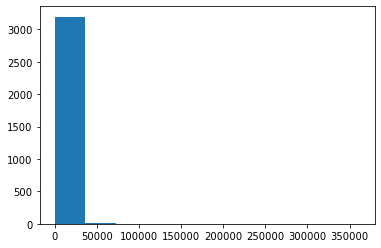

In [143]:
plt.hist(x[3,:])

In [87]:
np.savetxt(results_dir+'fc_demo_dmemfu1_r2.txt', r2, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_var.txt', var, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_corr.txt', corr, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_alpha.txt', opt_alpha, delimiter=',')

np.savetxt(results_dir+'fc_demo_dmemfu1_featimp.txt', featimp, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_preds.txt', preds, delimiter=',')
np.savetxt(results_dir+'fc_demo_dmemfu1_cogtest.txt', cogtest, delimiter=',')


In [88]:
A = np.zeros([perm,n_feat])

#iterate through permutations
for p in range(perm):
    print('Permutation %d' %(p+1))

    cov_x= np.zeros([n_feat])
    x_train, x_test, cog_train, cog_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=p)

    #compute covariance of training X data
    cov_x = np.cov(np.transpose(x_train))

    #for each of the cognitive scores
    for i in range(n_cog):
        #compute covariance of training cognitive scores
        cov_y = np.cov(cog_train[:,i])
        #compute activation vector by matrix multiplying training X covariance, feature weights, and 1/training Y covariance 
        A[p,:] = np.matmul(cov_x,featimp[p,:])*(1/cov_y)


A_avg = np.mean(A,axis=0)
np.savetxt(results_dir+'fc_demo_demo_dmemorig_featimpA_dmemfu1.txt', A_avg, delimiter=',')

Permutation 1
Permutation 2
Permutation 3
Permutation 4
Permutation 5
Permutation 6
Permutation 7
Permutation 8
Permutation 9
Permutation 10
Permutation 11
Permutation 12
Permutation 13
Permutation 14
Permutation 15
Permutation 16
Permutation 17
Permutation 18
Permutation 19
Permutation 20
Permutation 21
Permutation 22
Permutation 23
Permutation 24
Permutation 25
Permutation 26
Permutation 27
Permutation 28
Permutation 29
Permutation 30
Permutation 31
Permutation 32
Permutation 33
Permutation 34
Permutation 35
Permutation 36
Permutation 37
Permutation 38
Permutation 39
Permutation 40
Permutation 41
Permutation 42
Permutation 43
Permutation 44
Permutation 45
Permutation 46
Permutation 47
Permutation 48
Permutation 49
Permutation 50
Permutation 51
Permutation 52
Permutation 53
Permutation 54
Permutation 55
Permutation 56
Permutation 57
Permutation 58
Permutation 59
Permutation 60
Permutation 61
Permutation 62
Permutation 63
Permutation 64
Permutation 65
Permutation 66
Permutation 67
Perm